Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Мелехова Екатерина"
COLLABORATORS = ""

---

# Метод наименьших квадратов (линейный случай).

Рассмотрим функцию $y = f(x)$ определенной набором значений $y_0, y_1, \cdots, y_n$ в точках $x_0, x_1, \cdots, x_n$.

In [1]:
import numpy as np

x = np.asarray([-1, -0.7, -0.43, -0.14, 0.14, 0.43, 0.71, 1, 1.29, 1.57, 1.86, 2.14, 2.43, 2.71, 3])
y = np.asarray([-2.25, -0.77, 0.21, 0.44, 0.64, 0.03, -0.22, -0.84, -1.2, -1.03, -0.37, 0.61, 2.67, 5.04, 8.90])

rng = np.random.default_rng(123)
x += 0.1 * rng.uniform(size=len(x))
y += 4 * rng.uniform(size=len(x))

### I. Найдите многочлен наилучшего приближения,

$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

используя линейный метод наименьших квадратов.Для этого:

1. реализуйте алгоритм, создающий  "design matrix" `А`, используя $1, x, \cdots, x^m$ в качестве базисных функций.

2. постройте явно нормальную систему уравнений задачи наименьших квадратов при фиксированных значениях $m$.

3. решите систему уравнений, чтобы найти коэффициенты $P_m(x)$ для $m = 0, 1, 2, \dots$. Для решения задач линейной алгебры можете использовать либо библиотечные функции (`numpy.linalg.solve`), либо Вашу реализацию LU - разложение из 1 недели.

In [4]:
import numpy as np

def design_matrix(x, m):
    """Construct the design matrix with monomials x**k for k=0..m-1""" 
    A = np.empty((len(x), m), dtype=float)
    for k in range(0, m):
        A[:, k] = [q**k for q in x]
    return A

In [5]:
assert design_matrix(x, 3).shape == (len(x), 3)
assert design_matrix(x, 11).shape == (len(x), 11)

In [6]:
def lsq_poly(x, y, m):
    """Construct the LSQ polynomial of degree `m-1`.
    
    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The number of coefficients of the LSQ polynomial
        (i.e. the degree of the polynomial is `m-1`)
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
        
    Examples
    --------
    >>> p = lsq_poly([1, 2, 3], [4, 5, 6], m=2)
    >>> p(np.array([1.5, 2.5]))
    array([4.5, 5.5])
    
    """
    x = np.array(x)
    y = np.array(y)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Expect paired data.")
    if x.shape[0] <= m:
        raise ValueError("Cannot fit a degree-%s polynomial through %s points" % (m, x.shape[0]))
    
    A = design_matrix(x, m)
    right_part = np.linalg.inv(A.T@A)@A.T
    p = np.polynomial.Polynomial(right_part.dot(y))
    beta = right_part.dot(y) # решение уравнения
    return p  
        


In [7]:
import pytest
with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2], m=1)

with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2, 3], m=3)
    
# test that lsq_poly returns a callable object
# which support vectorized evaluation
p = lsq_poly(x, y, m=3)
assert len(p(x)) == len(x)

Вычислите число обусловленности матрицы `A` и матрицы левой части системы нормальных уравнений в зависимости $m$, и напечатайте их на экран.
Прокомментируйте полученные результаты.

In [8]:
for m in range(1, 10):
    A = design_matrix(x, m)
    cond_A = np.linalg.cond(A)
    print('A:\t', cond_A)
    cond_A_T_A = np.linalg.cond(A.T @ A)
    print('A_T_A:\t', cond_A_T_A)
    print()

A:	 1.0
A_T_A:	 1.0

A:	 2.5436796556599037
A_T_A:	 6.470306190618082

A:	 7.974123103608089
A_T_A:	 63.58663927149611

A:	 33.65632525997137
A_T_A:	 1132.7482300049778

A:	 149.21938644682763
A_T_A:	 22266.42529156567

A:	 709.1637406918856
A_T_A:	 502913.21111292107

A:	 3627.8477937658618
A_T_A:	 13161279.6151521

A:	 18346.19889548623
A_T_A:	 336583014.09533143

A:	 102424.5975675104
A_T_A:	 10490798212.051163



In [9]:
# This cell is a test: keep it intact


### II. Многочлен наилучшего приближения.

Ясно, что бесконтрольно увеличивать степень аппроксимирующего многочлена довольно бессмысленно. Зададимся целью построить "оптимальный" многочлен как можно более низкой степени $m$.

Для нахождения оптимального значения $m$ используйте следующий критерий: возьмем $m = 1, 2, \dots$, и для каждого значения $m$ вычислим

$$
\sigma_m^2 = \frac{1}{n - m} \sum_{k=0}^n \left( P_m(x_k) - y_k \right)^2
$$

и возьмем такое значение $m$, при котором $\sigma_m$ стабилизируется или начинает расти.

In [10]:
def sigma(x, y, m):
    r"""Compute $\sigma_m$."""
    n = len(y)
    SUM = 0
    p = lsq_poly(x, y, m)
    for k in range(n):
        SUM += (p(x[k]) - y[k])**2
    sigma_2 = SUM / (n - m)
    return sigma_2

In [11]:
for m in range(1, 15):
    print(m, sigma(x, y, m))

1 11.457382047310075
2 8.520081963394482
3 4.00556405823897
4 1.1356406880121819
5 1.1272670188279155
6 1.1208555131773152
7 1.0050279843985317
8 1.1003064743050361
9 1.2659515051676002
10 0.770119122303984
11 0.15965009694831334
12 0.174307998486898
13 0.21747791295259944
14 376.65252083584085


Постройте ваши полиномы $P_m(x)$ вместе с данными. Визуально сравните полиномы различных степеней. Согласуется ли визуальное сравнение с ожидаемым оптимальным значением $m$?

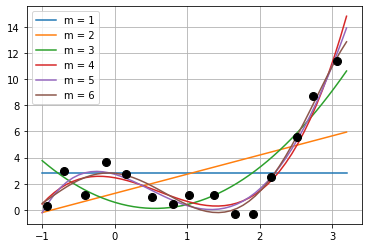

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for m in range(1, 7):
    p = lsq_poly(x, y, m)
    
    xx = np.linspace(-1, 3.2, 51)
    ax.plot(xx, p(xx), '-', label='m = %s' % m)

ax.plot(x, y, 'o', ms=8, color='k')
plt.legend(loc='best')
plt.grid()

### III. МНК с использованием QR-разложения.

Для оптимального значения $m$ из предыдущей части решите задачу МНК, QR-разложение design матрицы. Для решения задач линейной алгебры можете использовать библиотечные функции (обратите внимание на `scipy.linalg.solve_triangular` и `scipy.linalg.qr` и т.д.) или код предыдущих недель.
Сравните результат с ответом, полученным при решении системы уравнений.

In [13]:
from scipy import linalg
def lsq_qr(x, y, m):
    """Solve the LSQ problem via the QR decomp of the design matrix.

    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The degree of the LSQ polynomial
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
    
    """
    A = design_matrix(x, m)
    Q, R = linalg.qr(A)
    vector = Q.T@y
    vector_f = vector[:m]
    
    p = np.polynomial.Polynomial(np.linalg.inv(R[:m])@vector_f)
    return p

In [14]:
from numpy.testing import assert_allclose

for m in range(1, 10):
    assert_allclose(lsq_qr(x, y, m=m).coef,
                    lsq_poly(x, y, m=m).coef,
                    atol=1e-14)

In [15]:
# This cell spot-tests several polynomials to make sure that they are worse than your ``best'' polynomial.

